# Download Correction Files

This python script is aimed at automatically downloading the correction files essential for **PPK** of GNSS data.

**PPK** is a technique used to enhnace postional accuracy using observations of an other base station for exemple permanent stations.

To apply **PPK**, we need download:

1. Observation and navigation files of a permanent station near to the mission.
2. Precise orbits file

A large percentage of the GNSS sites provide broadcast navigation data in addition to observation data.

A File Transfer Protocol (*FTP*) is used to connect with this websites to download the files.

Package Requirements:

- gnsscal
- hatanaka

## Importing Packages 

In [13]:
import os, sys, subprocess, datetime, shutil
import gnsscal #A package for converting between Gregorian date and GNSS calender
import ftplib as ftp # for connect with the website
import hatanaka # for file decompression (RINEX files have a different compression)
from pathlib import Path

## Speficy directories and the name of the permanent station

In [14]:
base_station='WIND' #Name of the permanent station
path='C:/Users/bourriz/GNSS-Correction-RTKLIB-master/UIS_PosPac_HyspexNav_processing/Result/'
obs='C:/Users/bourriz/GNSS-Correction-RTKLIB-master/UIS_PosPac_HyspexNav_processing/Result/Rover/5905C00224202112030934-5905C00224202112031022.obs' #Path of the observation file of the rover

## Creating a function for downloading the files

In [15]:
def download_corr(obs:str,base_station:str,path:str):
    
 #Downloading correction files:
 #inputs:
    
 #obs: Path of the observation file of the rover (UAV)
 #base_station: The name of the permanent station
 #path: Main path of the result
 #outputs:
    
 #date
 #year
 #Day of year
 #GPS Week
 #GPS Week day
 #Permanent_obs_path: the path to the observation file of the permanent station
 #Permanent_nav_path: the path to the navigation file of the permanent station
 #Orbital_file_path: the path to the orbital file

 name=obs.split('/')[-1].split('.obs')[0]

 #We need read the rinex file for get the YY, DOY
 
 f=open(obs,'r').read()
 print(f'Downloading correction data for {name}')
 lines=f.strip().splitlines()
 for l in lines:
    if l.endswith('TIME OF FIRST OBS'):
     line=l.split()
     YY=line[0]
     MM=line[1]
     DD=line[2]

     #Converting to Date

     date=datetime.date(int(YY),int(MM),int(DD))

     #Converting to DOY (Day of Year)

     DOY=gnsscal.date2doy(date)
     if len(str(DOY))<3:
        DOY="0"+ str(DOY)

     #Getting the GPS WEEK & GPS WEEK DAY

     WWWW=gnsscal.date2gpswd(date)[0]
     WWWWD=str(gnsscal.date2gpswd(date)[0]) + str(gnsscal.date2gpswd(date)[1])
     print('Date: ',date)
     print('Year: ', YY)
     print('Day of year : ', DOY)
     print('GPS WEEK : ',WWWW)
     print('GPS WEEK DAY: ', WWWWD)

#Create a file for put the corrections

 corrections=path+'Corrections_files/'
 if not os.path.exists(corrections):
   os.mkdir(corrections)
 else:
   print(f'{corrections} is already created')

#Download the correction files using FTP server
#Permanent station (obs)

 server=ftp.FTP('gssc.esa.int')
 try:
   server.login() #Anonymous login
   print('Connected to the server')
 except:
   print('Couldnt connect')
   sys.exit() 
 directory='/ign/gnss/data/daily/'+str(YY)+'/'+str(DOY)+'/'

#Road to the directory
 server.cwd(directory)
 print('In the directory')

 file_station=base_station + '*30S*.crx.gz'
 for filename in server.nlst(file_station):
    file_obs_name = os.path.join(corrections,os.path.basename(filename))
    if not os.path.exists(file_obs_name.split('\\')[-1].split('.crx')[0]):
      with open(file_obs_name,'wb') as f:
         server.retrbinary('RETR %s' %filename, f.write)
            # quit and close server connection
         server.quit()
         server.close()
         print('downloading done')
    else:
     print('The Permanent observation file Already downloaded')

 decompressed_obs_path=Path(str(hatanaka.decompress_on_disk(file_obs_name)).replace('\\','/')) #decompression
 Observation_file = str(decompressed_obs_path).split('/')[-1].split('.rnx')[0] +'.obs'
 shutil.move(decompressed_obs_path, Observation_file)

#Permanent station (nav)

 server=ftp.FTP('gssc.esa.int')
 try:
   server.login() #Anonymous login
   print('Connected to the server')
 except:
   print('Couldnt connect')
   sys.exit()
 directory_nav='/ign/gnss/data/daily/'+str(YY)+'/'+str(DOY)+'/'

#Road to the directory
 server.cwd(directory_nav)
 print('In the directory')
 file_station = 'brdc' + str(DOY) + '0.'+ YY[2:] +'n.gz'
 print(f'Navigation file to retrieve {file_station}') 
 for filename in server.nlst(file_station):
  file_nav_name =os.path.join(corrections,os.path.basename(filename))
 with open(file_nav_name,'wb') as f:
    server.retrbinary('RETR %s' %filename, f.write)
        # quit and close server connection
    server.quit()
    server.close()
    print('downloading done') 
    # decompress the file
 decompressed_path = hatanaka.decompress_on_disk(corrections+filename)
    # final filename
 Navigation_file = str(decompressed_path)
 print('decompression done')
#Precise orbits(.sp3)

 server=ftp.FTP('gssc.esa.int')
 try:
   server.login() #Anonymous login
   print('Connected to the server')
 except:
   print('Couldnt connect')
   sys.exit()
 directory_orb='/gnss/products/'+str(WWWW)+'/'

#Road to the directory
 server.cwd(directory_orb)
 print('In the directory')
 try:
  filename = 'gfz' + WWWWD + '.sp3.Z'
  orbit_file_name = os.path.join(corrections,os.path.basename(filename))
  print(f'Orbital file to retrieve {filename}')
  with open(orbit_file_name,'wb') as fhandle:
    server.retrbinary('RETR %s' %filename, fhandle.write)
    server.quit()
    server.close()

    print('downloading done') 
    # retry with the rapid orbits if that didn't work
 except:
  filename = 'igr' + WWWWD + '.sp3.Z'
  orbit_file_name = os.path.join(corrections,os.path.basename(filename))
  print(f'Orbital file to retrieve {filename}') 
  with open(orbit_file_name,'wb') as fhandle:
    server.retrbinary('RETR %s' %filename, fhandle.write)
    server.quit()
    server.close()
    print('downloading done') 
    # decompress the file   
 decompressed_path = hatanaka.decompress_on_disk(corrections + filename)
    # final filename
 Orbital_Files= str(decompressed_path)
 print('decompression done')
 print('All the files are Downloaded')
 for file in os.listdir(corrections):
    Permanent_obs_path=os.path.join(corrections,'WIND00NAM_R_20213370000_01D_30S_MO.obs')
    Permanent_nav_path=os.path.join(corrections,'brdc3370.21n')
    Orbital_file_path=os.path.join(corrections,'gfz21865.sp3')
 return date,DOY,WWWW,WWWWD,Permanent_obs_path,Permanent_nav_path,Orbital_file_path

In [16]:
#Downloading the files
date,DOY,WWWW,WWWWD,Permanent_obs_path,Permanent_nav_path,Orbital_file_path=download_corr(obs,base_station,path)

Date:  2021-12-03
Year:  2021
Day of year :  337
GPS WEEK :  2186
GPS WEEK DAY:  21865
C:/Users/bourriz/GNSS-Correction-RTKLIB-master/UIS_PosPac_HyspexNav_processing/Result/Corrections_files/ is already created
Connected to the server
In the directory
downloading done
Connected to the server
In the directory
Navigation file to retrieve brdc3370.21n.gz
downloading done
decompression done
Connected to the server
In the directory
Orbital file to retrieve gfz21865.sp3.Z
downloading done
decompression done
All the files are Downloaded


#  Quality Check

Before apply any correction, we need check and analyze the observation data quality.

To do this, various types of quality indicators for observation and navigation data can be displayed such as *sky-plot*, *band-plot* and *DOP* values.

This python script aims to check the quality of the downloaded correction files before using them in the **PPK** correction.

Package Requirements:

- Numpy.
- Pandas.
- Matplotlib.
- gnss_lib_py.
- gnsspy.

## Importing Packages

In [17]:
import gnsspy as gp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gnss_lib_py as glp
from datetime import datetime, timezone
import matplotlib.dates as mdates
%matplotlib widget

## Sky-plot

A Sky-plot refers to a graphical representation that shows the location of satellites in the sky relative to a specific location allowing the users to understand satellite visibitily and availability.
The representation is in form of an inner circle representing the mask angle, which is a user-defined cut-off angle below which satellites are considered to be obstructed by terrain or other obstacles. Satellites within this inner circle would not typically be used in a GNSS solution.

In [18]:
#Read the observation file of the permanent station
obs_path=Permanent_obs_path
station=gp.read_obsFile(obs_path)

C:/Users/bourriz/GNSS-Correction-RTKLIB-master/UIS_PosPac_HyspexNav_processing/Result/Corrections_files/WIND00NAM_R_20213370000_01D_30S_MO.obs exist in working directory | Reading...
Observation file  C:/Users/bourriz/GNSS-Correction-RTKLIB-master/UIS_PosPac_HyspexNav_processing/Result/Corrections_files/WIND00NAM_R_20213370000_01D_30S_MO.obs  is read in 6.48 seconds.


In [19]:
#Specify the time of start and of end
timestamp_start = datetime(year=2021, month=12, day=3,hour=9 , tzinfo=timezone.utc)
timestamp_end = datetime(year=2021, month=12, day=3,hour=12 , tzinfo=timezone.utc)

In [20]:
#Convert the format datetime to gps millis
gps_millis = glp.datetime_to_gps_millis(np.array([timestamp_start,timestamp_end]))

In [21]:
#Get the approximative position of the permanent station (it's mention in the header of the observation file)
x_rx_m=station.approx_position[0]
y_rx_m=station.approx_position[1]
z_rx_m=station.approx_position[2]

In [22]:
#Read the orbital file (igs), u can also use other orbital file (e.g gfz)
sp3_path=Orbital_file_path
sp3 = glp.Sp3(sp3_path)

In [23]:
#Create a new NavData
receiver_state=glp.NavData()
receiver_state["gps_millis"] = glp.datetime_to_gps_millis(timestamp_start)
receiver_state["x_rx_m"] = x_rx_m
receiver_state["y_rx_m"] = y_rx_m
receiver_state["z_rx_m"] = z_rx_m
receiver_state

     gps_millis        x_rx_m       y_rx_m        z_rx_m
0  1.322557e+12  5.633709e+06  1732017.696 -2.433986e+06

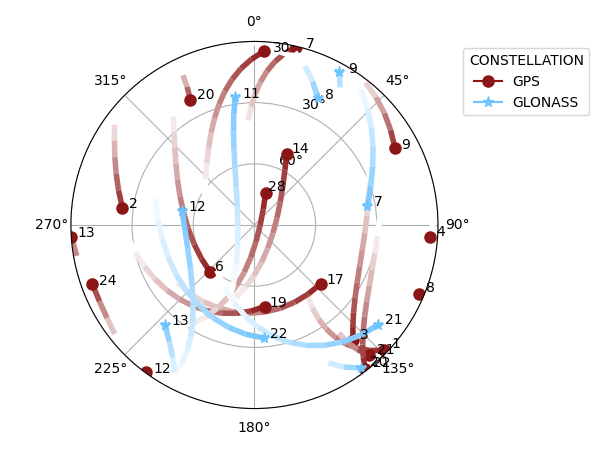

In [24]:
#Plot the skyplot of the specified time
cropped_sp3 = sp3.where("gps_millis",gps_millis[0],"geq").where("gps_millis",gps_millis[1],"leq")
fig = glp.plot_skyplot(cropped_sp3,receiver_state)